In [73]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/hush-finalProject/

In [74]:
from keras.datasets import mnist
from keras.layers import Dense , Flatten ,Reshape,Conv2D,Conv2DTranspose,BatchNormalization,Activation,LeakyReLU
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import dataset as da


In [75]:
#data
Xtrain  = da.final
Xtrain = np.expand_dims(Xtrain,3)
#normalization of data (-1,1)
# normx=np.linalg.norm(Xtrain)
# xx = np.expand_dims(Xtrain,3)/normx
# Xtrain.mean
# from sklearn.preprocessing import normalize
# xx=[]
# for i in range(Xtrain.shape[0]):
#   xx.append(normalize(Xtrain[i])*255)
# xx = np.asarray(xx)

In [76]:
# xx[0]

In [77]:
Xtrain[681]

array([[[  264],
        [   70],
        [ -155],
        ...,
        [ -418],
        [  -98],
        [  169]],

       [[  353],
        [  446],
        [  463],
        ...,
        [   96],
        [ -186],
        [ -551]],

       [[ -877],
        [-1038],
        [-1013],
        ...,
        [ 2374],
        [ 2396],
        [ 2390]],

       ...,

       [[   21],
        [   21],
        [   22],
        ...,
        [  -89],
        [  -86],
        [  -86]],

       [[  -84],
        [  -80],
        [  -74],
        ...,
        [   86],
        [   83],
        [   82]],

       [[   81],
        [   79],
        [   75],
        ...,
        [  -59],
        [  -56],
        [  -53]]], dtype=int16)

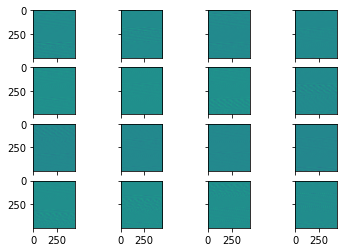

In [78]:
#show

def show(X ,r=4 ,c=4):
  fig,ax =plt.subplots(r,c,True,True)
  for i in range(r):
    for j in range(c):
      ax[i][j].imshow(X[i*c + j , :,:,0])
  plt.show()

show(Xtrain)

In [79]:
#noise for generator
z_dim = 100
img_shape =500,441

In [80]:
#discriminator

def buildDisc(img_shape=(500,441)):
  model = Sequential()
  model.add(Conv2D(64,3,(2,3),'same',input_shape=(*img_shape,1)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Conv2D(128,3,(2,3),'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Flatten())
  model.add(Dense(1))
  return model

disc = buildDisc()
disc.compile(optimizer=Adam(1e-4),loss=BinaryCrossentropy(True) ,metrics=['acc'])
disc.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 250, 147, 64)      640       
_________________________________________________________________
batch_normalization_24 (Batc (None, 250, 147, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 250, 147, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 125, 49, 128)      73856     
_________________________________________________________________
batch_normalization_25 (Batc (None, 125, 49, 128)      512       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 125, 49, 128)      0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 784000)          

In [81]:
#generator

def buildGen(z_dim=100 ,img_shape=(500,441)):
  model = Sequential()
  model.add(Dense(125*49*128,input_shape=(z_dim,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Reshape((125,49,128)))
  model.add(Conv2DTranspose(64,(5,5),(2,3),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Conv2DTranspose(1,(5,5),(2,3),padding='same',activation='tanh'))
  return model


In [82]:
#GAN

def buildGan(disc,gen):
  model=Sequential()
  model.add(gen)
  model.add(disc)
  return model

In [83]:
disc = buildDisc()
disc.compile(optimizer=Adam(1e-4),loss=BinaryCrossentropy(True) ,metrics=['acc'])
# disc.compile(optimizer=Adam(1e-4),loss='binary_crossentropy' ,metrics=['acc'])
gen = buildGen()

disc.trainable = False

gan = buildGan(disc,gen)
gan.compile(optimizer=Adam(1e-4),loss=BinaryCrossentropy(True))
# gan.compile(optimizer=Adam(1e-4),loss='binary_crossentropy')

Iteraition 50:	D acc:1.0	D loss:0.0005759926280006766	G loss:2.1348536014556885


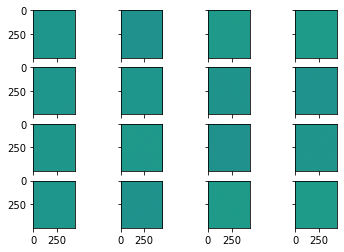

Iteraition 100:	D acc:1.0	D loss:0.0019157123751938343	G loss:3.102627754211426


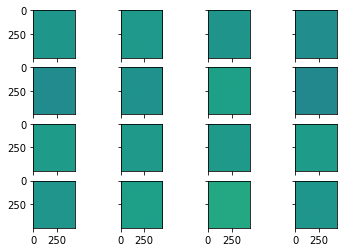

In [ ]:
#compile
batch_size =32
for i in range(2000):
  indexes = np.random.permutation(len(Xtrain))[:batch_size]
  # indexes1 = np.ones_like(indexes)*4
  Xreal = Xtrain[indexes]
  yreal = np.ones((batch_size,))
  noise = np.random.randn(batch_size,z_dim)
  Xfake = gen.predict(noise)
  yfake = np.zeros_like(yreal)
  Xdisc = np.concatenate((Xreal,Xfake))
  ydisc = np.concatenate((yreal,yfake))

  d_loss , d_acc = disc.train_on_batch(Xdisc,ydisc)

  noise = np.random.randn(batch_size,z_dim)
  g_loss = gan.train_on_batch(noise,yreal)

  if not((i+1)%50):
    print(f'Iteraition {i+1}:\tD acc:{d_acc}\tD loss:{d_loss}\tG loss:{g_loss}')
    noise =np.random.randn(batch_size,z_dim)
    Xfake = gen.predict(noise)
    show(Xfake)
     








In [ ]:
# Xfake = np.squeeze(Xfake,3)
Xfake = np.reshape(Xfake,(batch_size,220500))
import scipy.io.wavfile as wav
import os
for i in range(Xfake.shape[0]):
  wav.write(os.path.join('res', f'res_{i}.wav'), 22050, Xfake[i])